<a href="https://colab.research.google.com/github/rubusarbaro/supplychain-forecast-FIME/blob/main/Multiplex_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##############################################################################
###                      FCST de temperatura                                ##
###                        S&OP                                             ##
###                     25/02/2025                                          ##
###                                       jose.mosquera@mercadolibre.com.mx ##
##############################################################################

En está practica se va a utilizar algunos algoritmo de ML los cuales son basados en estrategias de arboles.
Piensa en un arbol de decisión al ejemplo puesto a continuación de una persona menor a 30 años.  Algunos de ustedes diran que las afirmaciones puestas en la imagen son *Correctas* otros diran que están *Mal* y otros simplemente no responderan.  Las estrategias de Arboles en Machine Learning emulan el mismo caso sin considerar los estudiantes que no quieren responder jaja .

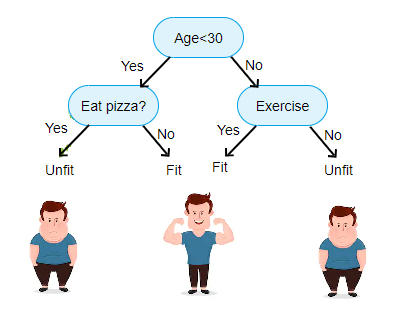


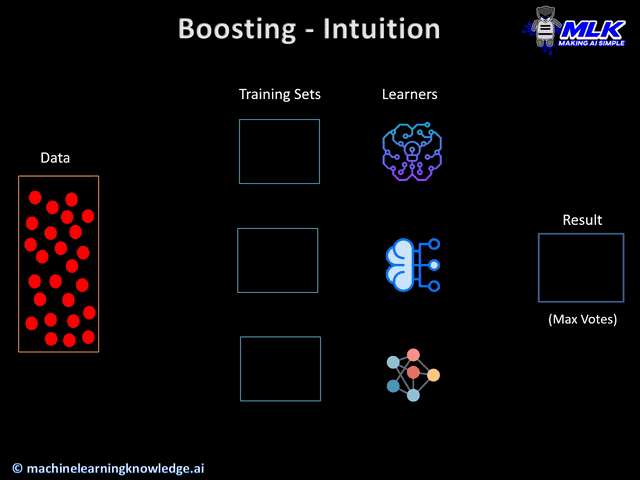

# Instalación de librerias

In [ ]:
!pip install --q catboost
!pip install --q skforecast
!pip install --q shap
!pip install --q meteostat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.6 MB/s eta 0:00:00


# Librerias

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from meteostat import Stations, Daily
import pytz

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from google.colab import drive
from google.colab import files
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [ ]:
import warnings

warnings.filterwarnings('ignore')

# Funciones

In [ ]:
def grafica_week( df, column_date, column_value,metrica,contexto):
  import plotly.express as px
  import plotly.graph_objects as go

  fig = go.Figure()

  b= df.groupby([column_date]).agg({column_value:'sum'}).round().reset_index()

  inferior_day=df[column_date].min().strftime('%Y-%m-%d')
  superior_day=df[column_date].max().strftime('%Y-%m-%d')

  colores=['royalblue',"#7FFF00",'#DAA520','darkcyan']
  ii=0
  fig.add_trace(go.Scatter(x=b[column_date], y=b[column_value], name='names',
                            line = dict(color=colores[ii], width=3, dash='dash')))
  fig.update_layout(title= "<b>"+ contexto + "<br>"  +"</b>"+  'Desde '+ "<b>"+str(inferior_day) +"</b>"+ ' hasta '+ "<b>" +
                    str(superior_day)+ "</b>" + "<br>", xaxis_title="Dia de la semana",yaxis_title=metrica)

  #fig.add_hline(y=90, line_width=3, line_dash="dash", line_color="green")
  #fig.add_hline(y=80, line_width=3, line_dash="dash", line_color="red")
  #fig.add_hrect(y0=60, y1=80, line_width=0, fillcolor="red", opacity=0.2)
  #fig.add_hrect(y0=90, y1=100, line_width=0, fillcolor="green", opacity=0.2)
  #fig.add_hrect(y0=80, y1=90, line_width=0, fillcolor="orange", opacity=0.2)

  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
  return fig



In [ ]:
def fortnight_end_month(string):
  if string in (14,15,16,30,31,1,2):
    return 1
  else:
    return 0



def transformacion(df, column_date):

  df[column_date] = pd.to_datetime(df[column_date])

  df['festivo']=df.apply(lambda x: es_festivo(x[column_date], x.PAIS) , axis=1)

  df['dayofweek'] = df[column_date].dt.dayofweek
  df['quarter'] = df[column_date].dt.quarter
  df['month'] = df[column_date].dt.month
  df['dayofyear'] = df[column_date].dt.dayofyear
  df['dayofmonth'] = df[column_date].dt.day
  #df['weekofyear'] = df[column_date].dt.weekofyear

  df['fortnight_end_month']=df['dayofyear'].apply(lambda x:  fortnight_end_month(x))

  year= list(set([df[column_date].min().year, df[column_date].max().year]))

  df=df.set_index(column_date)
  df = df.asfreq('D').sort_index()

  return df

def es_festivo(fecha, pais):
    import holidays
    from datetime import datetime
    # Convertir la fecha a formato datetime si no lo está
    if not isinstance(fecha, datetime):
        try:
            fecha = fecha  #datetime.strptime(fecha, '%Y-%m-%d')
        except ValueError:
            raise ValueError("Formato de fecha incorrecto. Debe ser 'YYYY-MM-DD'.")

    # Obtener los días festivos del país dado
    try:
        dias_festivos = holidays.CountryHoliday(pais)
    except KeyError:
        raise ValueError("País no encontrado en la lista de días festivos.")

    # Verificar si la fecha es un día festivo
    if fecha in dias_festivos:
        return 1
    else:
        return 0

def shiftting_data(data, col_names, n_backward_steps=1, n_forward_steps=1, dropnan=True):

    df = data.copy()

    cols, names = [], []

    for item in range(n_backward_steps, 0, -1):
        tmp = df.shift(item)
        tmp.columns = [f'{col}(t-{item})' for col in col_names]
        cols.append(tmp)
        del tmp

    for item in range(0, n_forward_steps):
      tmp = df.shift(-item)
      if item == 0:
          names += [f'{col}(t)' for col in col_names]
      else:
          names += [f'{col}(t-{item})' for col in col_names]
      tmp.columns = names
      cols.append(tmp)

    all_together = pd.concat(cols, axis=1)

    if dropnan:
        all_together.dropna(inplace=True)

    return all_together


def create_lag_features(df,column_time, lag=7):

    #df[f'Demand_Lag_{lag}'] = df[column_time].shift(lag)

    for i in [lag, 2*lag, 3*lag]:
        df[f'Demand_Lag_{i}'] = df[column_time].shift(i)
    return df

# Parametros

In [ ]:
coordenada1 =25.67507
coordenada2 = -100.31847

column_time= 'time'
colum_value='tavg'
column_value2= colum_value+'(t)'
title2= colum_value + '  Monterrrey'

metrica=colum_value.upper()

format_date_salida='%Y-%m-%d'
pais='MX'
datos_adelante=60

fecha_inicio='2024-01-01'
fecha_fin=  datetime.now(pytz.timezone('America/Mexico_City')).replace(tzinfo=None)

# Obtención de datos

***Paso 1:*** obtener los datos de meteostat, llevarlos un dataframe y filtrar para obtener la información de Monterrey.

Vamos a obtener los datos de una estación meteorologica de la ciudad de Monterrey.  Se está usando [Meteostat](https://dev.meteostat.net/python/) para tener los datos del clima

In [ ]:
stations = Stations()
stations = stations.nearby(coordenada1, coordenada2) # Coordenadas aproximadas de la Monterrey
station = stations.fetch(1) # Obtener la estación más cercana
station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
76394,Monterrey Airport,MX,NLE,76394,MMAN,25.8667,-100.2333,448.0,America/Monterrey,1973-01-01,2024-06-16,1973-03-07,2017-09-20,NaT,NaT,22951.661916


In [ ]:
# Obtener datos diarios para la estación más cercana a la Ciudad de México
start = datetime.strptime(fecha_inicio, format_date_salida)
end = fecha_fin.strftime("%Y-%m-%d")

data = Daily(station, start,end)
data = data.fetch()
data.head(2)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2024-01-01,15.5,9.2,23.0,0.0,NaN,334.0,9.0,NaN,1021.5,NaN
2024-01-02,14.2,11.0,18.0,4.5,NaN,62.0,7.9,NaN,1018.6,NaN


**Variables:**

- ***tavg***: Temperatura media o promedio diaria.
- ***tmin***: Temperatura mínima registrada en un día.
- ***tmax***: Temperatura máxima registrada en un día.
- ***prcp***: Precipitación total en milímetros o pulgadas para el día. Incluye lluvia, nieve, granizo, etc.
- ***snow***: Cantidad de nieve caída, generalmente en milímetros o centímetros equivalentes de agua.
- ***wdir***: Dirección promedio del viento en grados, donde 0 grados significa - viento soplando desde el norte.
- ***wspd***: Velocidad promedio del viento en kilómetros por hora o millas por hora.
- ***wpgt***: Racha de viento máxima, que es la velocidad más alta alcanzada por un golpe de viento.
- ***pres***: Presión atmosférica al nivel de la estación.
- ***tsun***: Duración de la insolación, que es el tiempo durante el cual un lugar recibe luz solar directa, medido en minutos u horas.

***Paso 2:*** Antes de suavizar los datos, es importante verificar la presencia de datos nulos y decidir cómo manejarlos.

In [ ]:
# Verificar datos nulos
print(data.isnull().sum())
# Suavizar los datos con un promedio móvil de 7 días
data_suavizada = data.rolling(window=7).mean()
# Suavizar los datos con un promedio móvil de 14 días
data_suavizada2 = data.rolling(window=14).mean()

tavg      0
tmin      0
tmax      0
prcp      0
snow    170
wdir      0
wspd      0
wpgt    170
pres      0
tsun    170
dtype: int64


In [ ]:
data.reset_index(inplace=True)

grafica_week(data, column_time,colum_value,metrica= metrica, contexto= title2)

Se ha agregado una columna la variable pais para poder automaticamente definir si un dia es festivo/asueto o no.  Adicionalmente se han puesto varios features de acuerdo al conocimiento de algunas variables. Finalmente se hace un shiff de todas las variables menos la "objetivo" para poder tener más información de la serie de tiempo.

# Crear Features

In [ ]:
df= data[[column_time,colum_value]]

df['PAIS']=pais
df= transformacion(df, column_time)
df= shiftting_data(df, df.columns, n_backward_steps=1, n_forward_steps=1, dropnan=True)
df.drop(['PAIS'+"(t-1)",'PAIS'+"(t)", colum_value+"(t-1)"], axis=1, inplace=True)

df.head(2)

,festivo(t-1),dayofweek(t-1),quarter(t-1),month(t-1),dayofyear(t-1),dayofmonth(t-1),fortnight_end_month(t-1),tavg(t),festivo(t),dayofweek(t),quarter(t),month(t),dayofyear(t),dayofmonth(t),fortnight_end_month(t)
time,,,,,,,,,,,,,,,
2024-01-02,1.0,0.0,1.0,1.0,1.0,1.0,1.0,14.2,0.0,1.0,1.0,1.0,2.0,2.0,1.0
2024-01-03,0.0,1.0,1.0,1.0,2.0,2.0,1.0,14.5,0.0,2.0,1.0,1.0,3.0,3.0,0.0


# Parametros para los modelos de ML

In [ ]:
porcent_train=0.8
porcent_validacion=0.9

forecaster1 = ForecasterAutoreg(
                  regressor = XGBRegressor(random_state=123),
                  lags = 24
              )

forecaster2 = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
             )

forecaster3 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 24
             )


param_grid_xgb = {
    'n_estimators': [100, 250,75,500],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.01, 0.1,0.15,0.2]
    }

param_grid_cat = {
        'n_estimators': [50,100, 250],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1,0.15]
    }

param_grid_random = {

     }




forecaster = [forecaster1,forecaster2, forecaster3  ]
param_grid_completo=[param_grid_xgb, param_grid_cat, param_grid_random  ]

estrategias=['XGB' ,'Cat','Random']


lags_grid = [72, 1, 2, 3, 23, 24, 25, 71, 72, 73]


#Ejecución de los modelos

In [ ]:
ssalida_exo= pd.DataFrame()
salida_full =pd.DataFrame()
salida=[]

insert_day= (datetime.now(pytz.timezone('America/Mexico_City'))  ).strftime("%Y-%m-%d %H:%M:%S")


for f in range(len(forecaster)):
  #try:
  df_sub = df.copy()
  df_sub.reset_index(inplace=True)

  date_range =df_sub[column_time].max() - df_sub[column_time].min()
  fin_train = (df_sub[column_time].min() + date_range * porcent_train).strftime("%Y-%m-%d")
  fin_validacion = (df_sub[column_time].min() + date_range * porcent_validacion).strftime("%Y-%m-%d")

  df_sub=df_sub.set_index(column_time)
  df_sub= df_sub.asfreq('D').sort_index()
  df_sub = df_sub.replace('#REF!', 0).astype(float)

  datos_train = df_sub.loc[df_sub.index<fin_train]
  datos_val   = df_sub.loc[(df_sub.index>=fin_train) & (df_sub.index<fin_validacion)]
  datos_test  = df_sub.loc[df_sub.index>=fin_validacion]

  columns= list(set(df_sub.columns)-set([column_value2]))

  y= df_sub[(df_sub.index<fin_validacion)]

  y=y[column_value2]

  exog = df_sub[(df_sub.index<fin_validacion)][columns]

  X_train = datos_train[columns]
  y_train = datos_train[column_value2]
  X_test =datos_test[columns]
  y_test = datos_test[column_value2]

  resultados_grid = grid_search_forecaster(
                          forecaster         = forecaster[f],
                          y                  = y,
                          exog               = exog,
                          param_grid         = param_grid_completo[f],
                          lags_grid          = lags_grid,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          initial_train_size = int(len(datos_train)),
                          return_best        = True,
                          verbose            = False
                    )

  metric, predicciones = backtesting_forecaster(
            forecaster         = forecaster[f],
            y                  = df_sub[column_value2],
            exog               = df_sub[columns],
            initial_train_size = int(len(df_sub.loc[:fin_validacion])),
            steps              = 36,
            refit              = False,
            metric             = 'mean_squared_error',
            verbose            = False
        )
  print('_'*40)
  print(f"Error de backtest: {metric:.2f}")
  print('_'*40)

  pred= predicciones.reset_index()
  pred.columns=[column_time,'pred']
  pred['estrategia']=estrategias[f]


  reales= df_sub[column_value2].reset_index()
  reales.columns=[column_time,'reales']
  salida_exo=pd.merge(pred, reales, on=column_time, how='left')

  salida.append(salida_exo)

  #except:
  #  continue

#salida= pd.concat(salida)


KeyError: 'time'

# Descarga de los datos

In [ ]:
j=1
forecaster[j].predict(steps=datos_adelante)

In [ ]:
df.to_csv('salida.csv',index=True,encoding='utf-8')

files.download('salida.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>